# Gutzwiller Using Split Evolution

The Gutzwiller wavefunction is found using a non-unitary operator.  Because quantum computers use unitary operations, it becomes tricky to implement the Gutzwiller wavefunction.  Here, I use the Split-Evolution technique described by other files in this folder.  The idea is to break the non-unitary operator into unitary parts and sum over these parts classically.   

The Gutzwiller wavefunction is,
$$ |\psi_g> = \frac{e^{-g \hat{D}} |\psi_0>}{\sqrt{<\psi_0|e^{-2g \hat{D}}|\psi_0>}} $$

where $|\psi_0>$ is the many-body ground state of the non-interacting system and $\hat{D}$ is the interaction part of the Hamiltonian.  Let's write $\hat{D}$ as a sum over operators.
$$ \hat{D} = \sum_{i}\hat{d}_i $$
where $d_i$ are some let of operators, for example: $\hat{d}_i = c_i^{\dagger}c_ic_{i+1}^{\dagger}c_{i+1}$.  Then we can write the non-unitary operator as,
$$ e^{-g \hat{D}} \approx \prod^{N_g} e^{-dg \hat{D}} \approx \prod^{N_g}\prod_i e^{-dg \hat{d}_i} = \prod^{N_g}\prod_i(\cosh(dg) - \sinh(dg)\hat{d}_i)$$

For the above approximations to hold, $dg$ must be small.  Since $dg$ is small we do not need to keep all order of $dg$ but instead can cut it off.  Therefore, the number of circuits we need does not grow exponentially with system size.  

In [2529]:
import qiskit.quantum_info as qi
import scipy as sp
import numpy as np
import pandas as pd

# Slatter Determinant

The Gutzwiller wavefunction uses the slatter determinant in its construction.  I want to first create the slatter determinant classically and then try to find a way to implement it on the quantum computer.

Let's use 
$$ \hat{K} = k \sum_{i\sigma} c^{\dagger}_{i\sigma}c_{i+1\sigma} + h.c.$$
as the example Hamiltonian.

## Single particle wavefunction

In [2530]:
def K(k,N):
    h = [[0 for i in range(N)] for ii in range(N)]
    h[0][N-1] = -k
    h[N-1][0] = -k
    for i in range(N-1):
        h[i][i+1] = -k
        h[i+1][i] = -k
    return h
#print(pd.DataFrame(K(k,N)))
      
#We know the eigenvalues and vectors
def E0(k,n,N):
    #return -2*k*np.cos((n+1)*np.pi/(N+1))
    return -2*k*np.cos(2*(n)*np.pi/(N))


def psi0(n,N):
    #y = [np.sqrt(2/(N+1))*np.sin((i+1)*(N-n)*np.pi/(N+1)) for i in range(N)]
    y = [np.sqrt(1/(N))*np.exp(1j*2*np.pi*(i)*(n)/N) for i in range(N)]
    return y



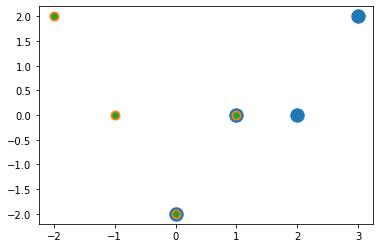

In [2534]:
import matplotlib.pyplot as plt

N=4
e,y = np.linalg.eig(K(k,N))
e = np.sort(e)
nl = [n for n in range(len(e))]
etst = [E0(k,n,N) for n in range(-int(N/2),int(math.ceil(N/2)))]
etst2 = [bkt(psi0(n,N),K(k,N),psi0(n,N)) for n in range(-int(N/2),int(math.ceil(N/2)))]
ntst = [n for n in range(int(-N/2),int(math.ceil(N/2)))]
plt.scatter(nl,e,s=180)
plt.scatter(ntst,etst,s=80)
plt.scatter(ntst,etst2,s=30)

## Creating the slater determinant from the single particle wavefunction

In [1866]:
#Creates all states with N fermions and S orbitals
def Generate_States(N,S):
    s = [i for i in range(0,N)]
    psi_l = []
    while s[0] < S-N:
        ### create the state and store it
        psi = 0
        for i in s:
            psi += 2**i
        psi_l.append(psi)
        ###
        ###Update the particle locations
        exit = 0
        i = len(s)-1
        while exit == 0:
            if s[i] < S-len(s)+i:
                s[i] += 1
                for j in range(i+1,len(s)):
                    s[j] = s[j-1]+1
                exit = 1
            else:
                i -= 1
        ###
    ###Create the finale state
    psi = 0
    for i in s:
        psi += 2**i
    psi_l.append(psi)
    ###
    return psi_l

# A function to print out the binary number
def bi(num,N):
    bi = bin(num)
    out = ""
    for i in range(2,len(bi)):
        out = out + bi[i]
    for i in range(len(out),N):
        out = '0' + out 
    return out


def generate_vectors(N,S):
    states = Generate_States(N,S)
    labels = [bi(s,S) for s in states]
    psi = {}
    for l in labels:
        psi[l] = qi.Statevector.from_label(l).data
    return psi

psi = generate_vectors(2,5)
print(psi.keys())
psi['10001']

dict_keys(['00011', '00101', '01001', '10001', '00110', '01010', '10010', '01100', '10100', '11000'])


array([0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j])

In [1867]:
def slat(X,N):
    e,y = np.linalg.eig(K(k,N))
    psi = np.transpose(y)
    odr = np.argsort(e)
    D = []
    for n in range(len(X)):
        Dx = []
        for x in X:
            Dx.append(psi[odr[n]][x])
        D.append(Dx)
    return D


def psi_slat(Ns,N):
    basis = generate_vectors(Ns,N)
    keys = list(basis.keys())
    psi = 0*basis[keys[0]]
    for key in keys:
        X = []
        for i in range(len(key)):
            if key[i] == '1':
                X.append(i)
        psi_key = np.linalg.det(slat(X,N))*basis[key]
        psi = psi + psi_key
    return psi
            
            
    

In [1868]:
psi_slat(3,4)

array([0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j,
       0.5+0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0.5+0.j, 0. +0.j, 0.5+0.j,
       0.5+0.j, 0. +0.j])

# Many Body 

## Hamiltonian

In [1869]:

def I(N):
    label = ['I' for i in range(N)]
    label = ''.join(label)
    return qi.Operator.from_label(label).data

def X(i,N):
    label = ['I' for i in range(N)]
    label[i] = 'X'
    label = ''.join(label)
    return qi.Operator.from_label(label).data

def Y(i,N):
    label = ['I' for i in range(N)]
    label[i] = 'Y'
    label = ''.join(label)
    return qi.Operator.from_label(label).data

def Z(i,N):
    label = ['I' for i in range(N)]
    label[i] = 'Z'
    label = ''.join(label)
    return qi.Operator.from_label(label).data

def c(i,N):
    label_1 = ['Z' for j in range(i)]
    label_2 = ['I' for j in range(i+1,N)]
    label_x = label_1 + ['X'] + label_2
    label_y = label_1 + ['Y'] + label_2
    label_x = ''.join(label_x)
    label_y = ''.join(label_y)
    x = qi.Operator.from_label(label_x).data
    y = qi.Operator.from_label(label_y).data
    return 1/2*(x+1j*y)

def cd(i,N):
    label_1 = ['Z' for j in range(i)]
    label_2 = ['I' for j in range(i+1,N)]
    label_x = label_1 + ['X'] + label_2
    label_y = label_1 + ['Y'] + label_2
    label_x = ''.join(label_x)
    label_y = ''.join(label_y)
    x = qi.Operator.from_label(label_x).data
    y = qi.Operator.from_label(label_y).data
    return 1/2*(x-1j*y)

import numpy as np

def Mdot(Ol):
    out = Ol[0]
    for i in range(1,len(Ol)):
        out = np.dot(Ol[i],out)
    return out

def bkt(y1,O,y2):
    return Mdot([np.conjugate(y1),O,y2])

In [1870]:
def Km(k,N):
    m = 0*I(N)
    for i in range(0,N-1):
        m = m + Mdot([cd(i,N),c(i+1,N)])+ Mdot([cd(i+1,N),c(i,N)])
    m = m + Mdot([cd(N-1,N),c(0,N)])+ Mdot([cd(0,N),c(N-1,N)])
    return m

In [1871]:
eM = Mdot([psi_slat(2,4),Km(1.5,4),psi_slat(2,4)])
diff_tst = np.amax(np.abs(Mdot([Km(1.5,4),psi_slat(2,4)]) - eM*psi_slat(2,4)))
e,y = np.linalg.eig(Km(1.5,4))
print("Is it an eigensate: ",diff_tst)
print("What is the expectation value: ", eM)
print("All eigenvalues:")
print(np.sort(e))

Is it an eigensate:  3.3306690738754696e-16
What is the expectation value:  (-1.9999999999999996+0j)
All eigenvalues:
[-2.00000000e+00+0.00000000e+00j -2.00000000e+00+0.00000000e+00j
 -2.00000000e+00+0.00000000e+00j -2.00000000e+00+0.00000000e+00j
 -4.44992209e-17-7.86143308e-17j -4.44992209e-17+7.86143308e-17j
  0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
  0.00000000e+00+0.00000000e+00j  4.09927614e-18+0.00000000e+00j
  7.77977866e-17+0.00000000e+00j  2.08579555e-16+1.23259516e-32j
  2.00000000e+00+0.00000000e+00j  2.00000000e+00+0.00000000e+00j
  2.00000000e+00+0.00000000e+00j  2.00000000e+00+0.00000000e+00j]


# Generate Slatter from Circuit

We restrict ourselves to the two particle space since this is the space the Hamiltoniain will act on.  I need to make sure that the Hamiltonian generated in "Example_matrix_creation" acts on the same basis as is generated for the slatter circuit.  

1) I need to translate the slatter weights onto the basis in which VQE is performed
    
    - First I restrict to two particle states
    
    -then I add spin
    
    -then I break the Hamiltonain into blocks
    
    -then I write onto a 2^q space leaving extra states empty

2) I need to generate the slatter state from unitary operators
    
    -using projectors and then completing the unitary could help
    
\begin{equation}
\begin{split}
&|0><0| = \frac{1}{2}(1+Z) \quad \quad |1><1| = \frac{1}{2}(1-Z)
\\
&|0><1| = \frac{1}{2}(X+iY) \quad \quad |1><0| = \frac{1}{2}(X-iY)
\end{split}
\end{equation}

## Translate to VQE basis

### Restrict onto the two particle states

In [1872]:
def generate_2P_vectors(N,S):
    states = Generate_States(N,S)
    labels = [bi(s,S) for s in states]
    psi = {}
    for l in range(len(labels)):
        psi_l = [0 for i in range(len(labels))]
        psi_l[l] = 1
        psi[labels[l]] = np.array(psi_l)
    return psi

def psi_2P_slat(Ns,N):
    basis = generate_2P_vectors(Ns,N)
    keys = list(basis.keys())
    psi = 0*basis[keys[0]]
    for key in keys:
        X = []
        for i in range(len(key)):
            if key[i] == '1':
                X.append(i)
        psi_key = np.linalg.det(slat(X,N))*basis[key]
        psi = psi + psi_key
    return psi
            
basis = generate_2P_vectors(2,4)
psi_2P_slat(2,4)

array([ 0.35355339,  0.70710678,  0.35355339,  0.35355339,  0.        ,
       -0.35355339])

In [1873]:
def Km_2P(Ns,N):
    basis = generate_vectors(Ns,N)
    keys = list(basis.keys())
    m = Km(Ns,N)
    m_2p = []
    for key1 in keys:
        ml = []
        psia = basis[key1]
        for key2 in keys:
            psib = basis[key2]
            h = bkt(psia,m,psib)
            ml.append(h)
        m_2p.append(ml)
    return np.array(m_2p)

print('H = ')
print(Km_2P(2,4))
e2p = bkt(psi_2P_slat(2,4),Km_2P(2,4),psi_2P_slat(2,4))
print( "Is the slatter wavevector an eighenvector?" , np.amax(np.abs(Mdot([Km_2P(2,4),psi_2P_slat(2,4)]) - e2p*psi_2P_slat(2,4))) )

H = 
[[ 0.+0.j -1.+0.j  0.+0.j  0.+0.j  1.+0.j  0.+0.j]
 [-1.+0.j  0.+0.j -1.+0.j -1.+0.j  0.+0.j  1.+0.j]
 [ 0.+0.j -1.+0.j  0.+0.j  0.+0.j -1.+0.j  0.+0.j]
 [ 0.+0.j -1.+0.j  0.+0.j  0.+0.j -1.+0.j  0.+0.j]
 [ 1.+0.j  0.+0.j -1.+0.j -1.+0.j  0.+0.j -1.+0.j]
 [ 0.+0.j  1.+0.j  0.+0.j  0.+0.j -1.+0.j  0.+0.j]]
Is the slatter wavevector an eighenvector? 3.3306690738754696e-16


### Add spin

In [1874]:
def psi_spin(Ns,N):
    return np.kron(psi_2P_slat(Ns,N),psi_2P_slat(Ns,N))

def K_spin(Ns,N):
    I0 = np.identity(len(Km_2P(Ns,N)))
    return np.kron(Km_2P(Ns,N),I0) + np.kron(I0,Km_2P(Ns,N))

psi_tst = psi_spin(2,4)
h_tst = K_spin(2,4)

e,y = np.linalg.eig(h_tst)
e = np.sort(e)
print('check eigenvector', np.amax(np.abs(Mdot([h_tst,psi_tst]) - bkt(psi_tst,h_tst,psi_tst)*psi_tst)) )
print("compare eigenvalue to bracket", e[0] - bkt(psi_tst,h_tst,psi_tst) )


check eigenvector 8.881784197001252e-16
compare eigenvalue to bracket (-8.881784197001252e-15-2.7155915767439864e-18j)


#### Gutzwiller on matrix

With spin included we can now test the Gutzwiler idea before we move on to breaking the Hamiltonian into blocks.  

The full Hamiltonian will be
$$ H = t\hat{K} + u\hat{D} $$
where
$$ \hat{D} = \sum_i \hat{n}_{i,\uparrow}\hat{n}_{i,\downarrow} $$

The Gutzwiller approach is to generate the eigenvector of the full Hamiltonian $ |\psi> $ from the eigenvector of the non-interacting Hamiltoniain $ |\psi_0> $ via
$$ |\psi> = \frac{e^{-g\hat{D}}|\psi_0>}{\sqrt{<\psi_0|e^{-2g\hat{D}}|\psi_0>}}$$

The idea is to then break up the exponential in small setps $dg$ such taht $N_g dg = g$.
$$ e^{-g\hat{D}} = \prod_{i=1}^N e^{-g \hat{n}_{i\uparrow}\hat{n}_{i\downarrow}}  $$
Since $\hat{D}$ is diagonal, this is exact.  Using J-W we have,
$$ e^{-g\hat{D}}  \rightarrow \prod_{i=1}^N e^{-\frac{g}{4} (I +Z_{i\uparrow} + Z_{i\downarrow} + Z_{i\uparrow}Z_{i\downarrow})} $$
$$ = \prod_{i=1}^N (\cosh(\frac{g}{4})-\sinh(\frac{g}{4}))(\cosh(\frac{g}{4})-\sinh(\frac{g}{4})Z_{i\uparrow})(\cosh(\frac{g}{4})-\sinh(\frac{g}{4})Z_{i\downarrow})(\cosh(\frac{g}{4})-\sinh(\frac{g}{4})Z_{i\uparrow}Z_{i\downarrow}) $$
$$ = (C^4 - C^3S + C^2S^2 - C S^3 + S^4)I + (2C^2S^2 - C^3S - CS^3)(Z_{i\uparrow} + Z_{i\downarrow} + Z_{i\uparrow}Z_{i\downarrow})$$


In [1875]:
print( sp.linalg.expm(-Mdot([cd(0,2),c(0,2),cd(1,2),c(1,2)])) )
    
C = np.cosh(1/4)
S = np.sinh(1/4)

(C**4 - C**3*S  - C*S**3 + S**4)*I(2) + (- C**3*S + C**2*S**2 + C**2*S**2 - C*S**3)*(Z(0,2) + Z(1,2) + Mdot([Z(0,2),Z(1,2)]) )  


[[0.36787944+0.j 0.        +0.j 0.        +0.j 0.        +0.j]
 [0.        +0.j 1.        +0.j 0.        +0.j 0.        +0.j]
 [0.        +0.j 0.        +0.j 1.        +0.j 0.        +0.j]
 [0.        +0.j 0.        +0.j 0.        +0.j 1.        +0.j]]


array([[0.36787944+0.j, 0.        +0.j, 0.        +0.j, 0.        +0.j],
       [0.        +0.j, 1.        +0.j, 0.        +0.j, 0.        +0.j],
       [0.        +0.j, 0.        +0.j, 1.        +0.j, 0.        +0.j],
       [0.        +0.j, 0.        +0.j, 0.        +0.j, 1.        +0.j]])

In [1876]:
def D(N):
    out = 0*I(2*N)
    for i in range(N):
        out = out + Mdot([cd(i,2*N),c(i,2*N),cd(i+N,2*N),c(i+N,2*N)])
    return out

def G(g,N):
    out = I(2*N)
    C = np.cosh(g/4)
    S = np.sinh(g/4)
    a = (C**4 - C**3*S  - C*S**3 + S**4)
    b = (- C**3*S + C**2*S**2 + C**2*S**2 - C*S**3)
    for i in range(N):
        out = Mdot([  out, a*I(2*N) + b*( Z(i,2*N) + Z(i+N,2*N) + Mdot([Z(i,2*N),Z(i+N,2*N)]) ) ]) 
    return out
        
np.amax(np.abs( sp.linalg.expm(-D(4)) - G(1,4) ))



8.881784197001252e-16

We want to write this in the 2 particle basis.  

In [1877]:
def states_full(states):
    keys = list(states.keys())
    out = {}
    for k in keys:
        for kk in keys:
            new_key = k+kk
            out[new_key] = np.kron(states[k],states[kk])
    return out

def D_spin(Ns,N):
    basis = states_full(generate_vectors(Ns,N))
    keys = list(basis.keys())
    m = D(N)
    m_2p = []
    for key1 in keys:
        ml = []
        psia = basis[key1]
        for key2 in keys:
            psib = basis[key2]
            h = bkt(psia,m,psib)
            ml.append(h)
        m_2p.append(ml)
    return np.array(m_2p)

def G_spin(g,Ns,N):
    basis = states_full(generate_vectors(Ns,N))
    keys = list(basis.keys())
    m = G(g,N)
    m_2p = []
    for key1 in keys:
        ml = []
        psia = basis[key1]
        for key2 in keys:
            psib = basis[key2]
            h = bkt(psia,m,psib)
            ml.append(h)
        m_2p.append(ml)
    return np.array(m_2p)

np.amax(np.abs( sp.linalg.expm(-D_spin(2,4)) - G_spin(1,2,4) ))

8.881784197001252e-16

In [1878]:
#one spin up one spin down
len(D_spin(1,4))
len(K_spin(1,4))
psi0 = psi_spin(1,4)

H = K_spin(1,4) + 10*D_spin(1,4)
e,y = np.linalg.eig(H)
y = np.transpose(y)
arg = np.argsort(e)
e = np.sort(e)

print( 'is psi0 an eigenstate of K:',np.amax(np.abs(np.dot(K_spin(1,4),psi0)  - bkt(psi0,K_spin(1,4),psi0)*psi0)) )



is psi0 an eigenstate of K: 4.440892098500626e-16


[16.85105379+0.j 18.        +0.j 18.        +0.j 19.61483519+0.j
 19.61483519+0.j 20.        +0.j 20.        +0.j 20.        +0.j
 20.        +0.j 22.        +0.j 22.        +0.j 22.35329173+0.j
 30.        +0.j 30.38516481+0.j 30.38516481+0.j 30.79565449+0.j]


/opt/miniconda3/envs/qiskit_u3.1/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


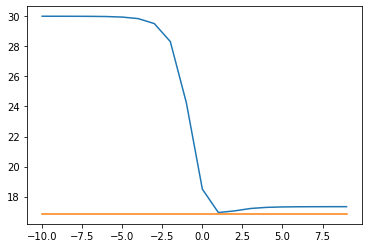

In [1879]:
#one spin up one spin down
eg = []
gl = []
eT = []
for gi in range(-10,10):
    g = gi
    expD = sp.linalg.expm(-g*D_spin(1,4))
    psi = Mdot([expD,psi_spin(1,4)])
    psi = psi/np.sqrt(Mdot([np.conjugate(psi),psi]))
    egl = bkt(psi,H,psi)
    eg.append(egl)
    gl.append(g)
    eT.append(e[0])

plt.plot(gl,eg)
plt.plot(gl,eT)
print(e)

true ground state energy: (-2.102748483462077+0j)
non-interacting ground state energy: (-3.9999999999999982+0j)
expectation value with psi0: (0.9999999999999993+0j)
[-2.10274848e+00+0.j -1.80642385e+00+0.j -1.06814039e+00+0.j
 -8.28427125e-01+0.j -8.28427125e-01+0.j -9.10047016e-16+0.j
  5.81449281e-01+0.j  2.00000000e+00+0.j  2.00000000e+00+0.j
  2.00000000e+00+0.j  2.00000000e+00+0.j  2.38787313e+00+0.j
  2.96539191e+00+0.j  3.17157288e+00+0.j  3.17157288e+00+0.j
  4.00000000e+00+0.j  4.00000000e+00+0.j  4.00000000e+00+0.j
  4.00000000e+00+0.j  4.00000000e+00+0.j  4.00000000e+00+0.j
  4.82842712e+00+0.j  4.82842712e+00+0.j  5.03460809e+00+0.j
  5.61212687e+00+0.j  6.00000000e+00+0.j  6.00000000e+00+0.j
  6.00000000e+00+0.j  6.00000000e+00+0.j  7.41855072e+00+0.j
  8.00000000e+00+0.j  8.82842712e+00+0.j  8.82842712e+00+0.j
  9.06814039e+00+0.j  9.80642385e+00+0.j  1.01027485e+01+0.j]


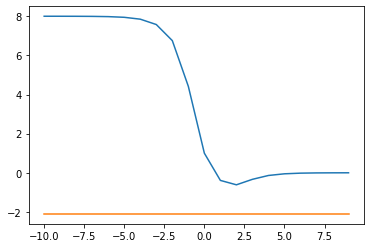

In [1880]:
#two spin up two spin down
H = K_spin(2,4) + 4*D_spin(2,4)
e,y = np.linalg.eig(H)
e = np.sort(e)

print('true ground state energy:', e[0])
print('non-interacting ground state energy:',bkt(psi_spin(2,4),K_spin(2,4),psi_spin(2,4)) )
print('expectation value with psi0:',bkt(psi_spin(2,4),H,psi_spin(2,4)) )

eg = []
eT = []
gl = []
for gi in range(-10,10):
    g = gi
    psi_g = Mdot([G_spin(g,2,4),psi_spin(2,4)])
    norm = 1/np.sqrt(Mdot([np.conjugate(psi_g),psi_g]))
    psi_g = norm*psi_g
    egl = bkt(psi_g,H,psi_g)
    eg.append(egl)
    gl.append(g)
    eT.append(e[0])

plt.plot(gl,eg)
plt.plot(gl,eT)
print(e)


### Break into blocks

In [1881]:
import math
import copy

def K_blocks(Ns,N):
    bL = math.comb(N,Ns)
    H_tu = K_spin(Ns,N)
    blocks = {}
    for bi in range(bL):
        for bj in range(bi,bL):
            bij = [[H_tu[i + bL*bi][j + bL*bj] for j in range(0,bL)] for i in range(0,bL)]
            blocks[str(bi) + ',' + str(bj)] = np.array(bij)
    return blocks

def D_blocks(Ns,N):
    bL = math.comb(N,Ns)
    H_tu = D_spin(Ns,N)
    blocks = {}
    for bi in range(bL):
        for bj in range(bi,bL):
            bij = [[H_tu[i + bL*bi][j + bL*bj] for j in range(0,bL)] for i in range(0,bL)]
            blocks[str(bi) + ',' + str(bj)] = np.array(bij)
    return blocks

def G_blocks(g,Ns,N):
    bL = math.comb(N,Ns)
    H_tu = G_spin(g,Ns,N)
    blocks = {}
    for bi in range(bL):
        for bj in range(bi,bL):
            bij = [[H_tu[i + bL*bi][j + bL*bj] for j in range(0,bL)] for i in range(0,bL)]
            blocks[str(bi) + ',' + str(bj)] = np.array(bij)
    return blocks

def psi_sets(Ns,N):
    bL = math.comb(N,Ns)
    psi = psi_spin(Ns,N)
    sets = {}
    for bi in range(bL):
        psi_i = [psi[i + bL*bi] for i in range(0,bL)]
        sets[str(bi)] = np.array(psi_i)
    return sets

def find_e(psi_tst,k_tst):
    etst = 0
    bL = len(psi_tst)
    for bi in range(bL):
        e11 = bkt(psi_tst[str(bi)],k_tst[str(bi) + ',' + str(bi)],psi_tst[str(bi)])
        etst += e11
        for bj in range(bi+1,bL):
            e12 = 2*bkt(psi_tst[str(bi)],k_tst[str(bi) + ',' + str(bj)],psi_tst[str(bj)])
            etst += e12
    return etst

def Bdot(M,Psi):
    bL = len(Psi)
    out = copy.deepcopy(Psi)
    for bi in range(bL):
        out[str(bi)] = Mdot([M[str(bi) + ',' + str(bi)],Psi[str(bi)]])
    for bi in range(bL):
        for bj in range(bi+1,bL):
            out[str(bi)] = out[str(bi)] + Mdot([M[str(bi) + ',' + str(bj)],Psi[str(bj)]])
            out[str(bj)] = out[str(bj)] + Mdot([np.conjugate(M[str(bi) + ',' + str(bj)]),Psi[str(bi)]])
    return out

def Bdot2(Psi1,Psi2):
    bL = len(Psi1)
    out = 0
    for bi in range(bL):
        out += Mdot([Psi1[str(bi)],Psi2[str(bi)]])
    return out


etst = find_e(psi_sets(2,4), K_blocks(2,4))
print('energy = ', etst)
epsi = Bdot(K_blocks(2,4),psi_sets(2,4))
keys = list(epsi.keys())
for key in keys:
    print( "check eigenvecor for set" + key , np.amax(np.abs( epsi[key] - etst*psi_sets(2,4)[key] )) )

energy =  (-3.999999999999999+0j)
check eigenvecor for set0 1.6653345369377348e-16
check eigenvecor for set1 4.440892098500626e-16
check eigenvecor for set2 2.220446049250313e-16
check eigenvecor for set3 2.220446049250313e-16
check eigenvecor for set4 2.7755575615628914e-17
check eigenvecor for set5 2.7755575615628914e-16


### Add zeros to fill $2^q$

In [2464]:
def complete_block_on(b11):
    b11 = list(b11)
    for i in range(len(b11)):
        b11[i] = list(b11[i])
    size = int(2**np.ceil(np.log2(len(b11))) )
    for v in b11:
        while len(v) < size:
            v.append(0.0)
    while len(b11) < size:
        i = len(b11)
        vnew = [0.0 for i in range(0,size)]
        vnew[i] = 0 #0 #1000
        b11.append(vnew)
    return np.array(b11)

def complete_block_off(b11):
    b11 = list(b11)
    for i in range(len(b11)):
        b11[i] = list(b11[i])
    size = int(2**np.ceil(np.log2(len(b11))) )
    for v in b11:
        while len(v) < size:
            v.append(0.0)
    while len(b11) < size:
        i = len(b11)
        vnew = [0.0 for i in range(0,size)]
        b11.append(vnew)
    return np.array(b11)

def complete_set(s1):
    s1 = list(s1)
    size = 2**np.ceil(np.log2(len(s1)))
    while len(s1) < size:
        s1.append(0)
    return np.array(s1)

def complete_blocks(blocks):
    keys = list(blocks.keys())
    for key in keys:
        if key[0] == key[2]:
            blocks[key] = complete_block_on(blocks[key])
        else:
            blocks[key] = complete_block_off(blocks[key])
    return blocks

def complete_sets(sets):
    kets = list(sets.keys())
    for key in keys:
        sets[key] = complete_set(sets[key])
    return sets


psi_comp =  complete_sets(psi_sets(2,4))
k_comp =  complete_blocks(K_blocks(2,4))


etst = find_e(psi_comp, k_comp)
print('energy = ', etst)
epsi = Bdot(k_comp,psi_comp)
keys = list(epsi.keys())
for key in keys:
    print( "check eigenvecor for set" + key , np.amax(np.abs( epsi[key] - etst*psi_comp[key] )) )

energy =  (-3.9999999999999996+0j)
check eigenvecor for set0 0.0
check eigenvecor for set1 6.661338147750939e-16
check eigenvecor for set2 2.220446049250313e-16
check eigenvecor for set3 0.0
check eigenvecor for set4 0.0
check eigenvecor for set5 2.220446049250313e-16


#### Do Gutzwiller on the sets

In [2465]:
def G_comp(g):
    return complete_blocks(G_blocks(g,2,4))
psi_comp =  complete_sets(psi_sets(2,4))
K_comp =  complete_blocks(K_blocks(2,4))
D_comp = complete_blocks(D_blocks(2,4))


H_comp = {}
for key in list(K_comp.keys()):
    H_comp[key] = K_comp[key] + 4*D_comp[key]
    
eg = []
eT = []
gl = []
for gi in range(-10,10):
    g = gi
    psi_g = Bdot(G_comp(g),psi_comp)
    norm = 1/np.sqrt(Bdot2(psi_g,psi_g))
    Hpsi_g = Bdot(H_comp,psi_g)
    egl = norm**2*Bdot2(psi_g,Hpsi_g)
    eg.append(egl)
    gl.append(g)
    eT.append(e[0])


/opt/miniconda3/envs/qiskit_u3.1/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


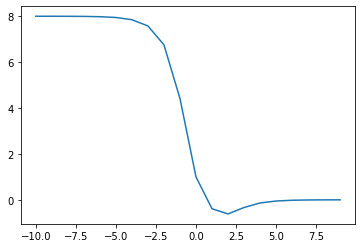

In [2466]:
plt.plot(gl,eg)

Note: the wavevectors are assumed to be real!

## Generate from quantum gates

### Find gates to generate Slater Determinant


We need to return these states

In [2467]:
psi_comp

{'0': array([ 0.125,  0.25 ,  0.125,  0.125,  0.   , -0.125,  0.   ,  0.   ]),
 '1': array([ 0.25,  0.5 ,  0.25,  0.25,  0.  , -0.25,  0.  ,  0.  ]),
 '2': array([ 0.125,  0.25 ,  0.125,  0.125,  0.   , -0.125,  0.   ,  0.   ]),
 '3': array([ 0.125,  0.25 ,  0.125,  0.125,  0.   , -0.125,  0.   ,  0.   ]),
 '4': array([ 0.,  0.,  0.,  0.,  0., -0.,  0.,  0.]),
 '5': array([-0.125, -0.25 , -0.125, -0.125, -0.   ,  0.125,  0.   ,  0.   ])}

These all hace the form:
$$ |\psi> = a |000> + b |001> + a |010> + a |011>  -a |101> $$

#### From Unitary

We can create a unitary which takes $|000> \rightarrow |\psi>$ by having the first row match the vector then find a set of orthoginal vectors to fill the remaining rows.

In [2468]:
U = 1/np.sqrt(2)*np.array([[0.5,1,0.5,0.5,0,-0.5,0,0],[0.5,0,-0.5,-0.5,1,-0.5,0,0],[1,0,0,0,0,1,0,0],[0,0,1,-1,0,0,0,0],[0.5,-1,0.5,0.5,0,-0.5,0,0],[0.5,0,-0.5,-0.5,-1,-0.5,0,0],[0,0,0,0,0,0,np.sqrt(2),0],[0,0,0,0,0,0,0,np.sqrt(2)]])




print('wave ',1/np.sqrt(8)*Mdot([U,[1,0,0,0,0,0,0,0]]))
print('Is U unitary:', np.amax(np.abs( Mdot([np.transpose(U),U]) - I(3) )) )
pd.DataFrame(U)



wave  [ 0.125  0.25   0.125  0.125  0.    -0.125  0.     0.   ]
Is U unitary: 2.220446049250313e-16


,0,1,2,3,4,5,6,7
0,0.353553,0.707107,0.353553,0.353553,0.000000,-0.353553,0.0,0.0
1,0.353553,0.000000,-0.353553,-0.353553,0.707107,-0.353553,0.0,0.0
2,0.707107,0.000000,0.000000,0.000000,0.000000,0.707107,0.0,0.0
3,0.000000,0.000000,0.707107,-0.707107,0.000000,0.000000,0.0,0.0
4,0.353553,-0.707107,0.353553,0.353553,0.000000,-0.353553,0.0,0.0
5,0.353553,0.000000,-0.353553,-0.353553,-0.707107,-0.353553,0.0,0.0
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0


In [2469]:
from qiskit import QuantumCircuit, transpile

qc = QuantumCircuit(3)
qc.unitary(U,[0,1,2])
qc.draw()

┌──────────┐
q_0: ┤0         ├
     │          │
q_1: ┤1 Unitary ├
     │          │
q_2: ┤2         ├
     └──────────┘

In [2535]:
qc_trans = transpile(qc,basis_gates = ['cx','u3'])
#qc_trans.draw()

#### Directly from state

In [2471]:
from qiskit import QuantumCircuit, transpile
psi = np.array([0.5,1,0.5,0.5,0,-0.5,0,0])/np.sqrt(2)

qc = QuantumCircuit(3)
qc.initialize(psi,[0,1,2])

qc.draw()

┌─────────────────────────────────────────────────────────────┐
q_0: ┤0                                                            ├
     │                                                             │
q_1: ┤1 Initialize(0.35355,0.70711,0.35355,0.35355,0,-0.35355,0,0) ├
     │                                                             │
q_2: ┤2                                                            ├
     └─────────────────────────────────────────────────────────────┘

In [2472]:
qc_trans = transpile(qc,basis_gates = ['cx','ry','rz'])
qc_trans.draw()

global phase: π/8
      ┌────────────┐                                                           »
q_0: ─┤ Ry(1.7317) ├───────────────────────────────────────────────────────────»
     ┌┴────────────┤           ┌───┐┌─────────────┐┌─────────┐┌───┐┌──────────┐»
q_1: ┤ Ry(0.56394) ├───────────┤ X ├┤ Ry(0.56394) ├┤ Rz(π/4) ├┤ X ├┤ Rz(-π/4) ├»
     ├─────────────┤┌─────────┐└─┬─┘└─────────────┘└─────────┘└─┬─┘└──────────┘»
q_2: ┤ Ry(0.72273) ├┤ Rz(π/4) ├──■──────────────────────────────■──────────────»
     └─────────────┘└─────────┘                                                »
«     ┌───┐┌─────────────┐┌───┐┌──────────────┐┌───┐┌─────────────┐┌──────────┐»
«q_0: ┤ X ├┤ Ry(0.94627) ├┤ X ├┤ Ry(-0.62452) ├┤ X ├┤ Ry(0.16088) ├┤ Rz(-π/4) ├»
«     └─┬─┘└─────────────┘└─┬─┘└──────────────┘└─┬─┘└─────────────┘└──────────┘»
«q_1: ──■───────────────────┼────────────────────■─────────────────────────────»
«                           │                                                  »
«q_2: ──────────────────────■──────────────────────────────────────────────────»
«                                                                              »
«     ┌───┐┌──────────┐┌───┐┌─────────┐┌───┐┌─────────┐
«q_0: ┤ X ├┤ Rz(-π/4) ├┤ X ├┤ Rz(π/4) ├┤ X ├┤ Rz(π/4) ├
«     └─┬─┘└──────────┘└─┬─┘└─────────┘└─┬─┘└─────────┘
«q_1: ──■────────────────┼───────────────■─────────────
«                        │                             
«q_2: ───────────────────■─────────────────────────────
«

## Gutzwiller using gates

There are two possible methods here.  1) we find the Pauli decomposition of the Gutzwiler blocks and multiply them directly to the circuits one by one.  2) we mutiply the Gutzwiler with the Hamiltoniain and find the puali decomposition of the entire matrix.  

We will use the second method since it requries fewer circuits.  

If we were not using blocks, we could find the Pauli decomposition by hand using 
$$ \hat{K} = k\sum_{i\sigma}\left(c^{\dagger}_{i\sigma}c_{i+1\sigma} +c ^{\dagger}_{i+1\sigma}c_{i\sigma} \right) $$

$$ \hat{D} = d\sum_{i\sigma}n_{i\uparrow}n_{i\downarrow} $$

$$ \hat{G} = \prod_{i}\left[ A(g) + B(g)(n_{i\uparrow}n_{i\downarrow} - 1) \right] $$

The form 
$$ H = \hat{G}(\hat{K} + \hat{D})\hat{G} $$

However, since we want to use the block formulation, we will simply let the computer find the Pauli decomposition for us.  

Remeber to take care of normalization

In [2473]:
def H_spin(k,d,Ns,N):
    return k*K_spin(Ns,N) + d*D_spin(Ns,N)

def GHG_spin(g,k,d,Ns,N):
    return Mdot([G_spin(g,Ns,N),H_spin(k,d,Ns,N),G_spin(g,Ns,N)])

def norm_spin(g,Ns,N):
    return Mdot([G_spin(g,Ns,N),G_spin(g,Ns,N)])

def GHG_blocks(g,k,d,Ns,N):
    bL = math.comb(N,Ns)
    H_tu = GHG_spin(g,k,d,Ns,N)
    blocks = {}
    for bi in range(bL):
        for bj in range(bi,bL):
            bij = [[H_tu[i + bL*bi][j + bL*bj] for j in range(0,bL)] for i in range(0,bL)]
            blocks[str(bi) + ',' + str(bj)] = np.array(bij)
    return blocks

def norm_blocks(g,Ns,N):
    bL = math.comb(N,Ns)
    H_tu = norm_spin(g,Ns,N)
    blocks = {}
    for bi in range(bL):
        for bj in range(bi,bL):
            bij = [[H_tu[i + bL*bi][j + bL*bj] for j in range(0,bL)] for i in range(0,bL)]
            blocks[str(bi) + ',' + str(bj)] = np.array(bij)
    return blocks

In [2474]:
def GHG_comp(g,k,d,Ns,N):
    return complete_blocks(GHG_blocks(g,k,d,Ns,N))

def norm_comp(g,Ns,N):
    return complete_blocks(norm_blocks(g,Ns,N))

def find_paulis(blocks):
    keys = list(blocks.keys())
    paulis = {}
    for key in keys:
        if np.amax(np.abs(blocks[key])) > 10**(-8):
            paulis[key] = MatrixOp(blocks[key]).to_pauli_op()
    return paulis



def GHG_paulis(g,k,d,Ns,N):
    return find_paulis(GHG_comp(g,k,d,Ns,N))

def norm_paulis(g,Ns,N):
    return find_paulis(norm_comp(g,Ns,N))

In [2475]:
#There is an issue with the second off diagonal braket 
def bkt_paulis(psi1,O,psi2):
    keys = list(O.keys())
    out = 0
    for key in keys:
        for pauli in O[key]:
            p = pauli.primitive.to_label()
            P = qi.Operator.from_label(p).data
            w = pauli.coeff
            if key[0] == key[2]:
                out += w*Mdot([np.conjugate(psi1[key[0]]) , P , psi2[key[2]] ])
            else:
                out += w*Mdot([np.conjugate(psi1[key[0]]) , P , psi2[key[2]] ])
                out += w*np.conjugate( Mdot([ psi1[key[0]] , P , psi2[key[2]] ]) )
    return out

In [2476]:
print ( 'check norm:',  bkt_paulis(psi_comp,norm_paulis(2,2,4),psi_comp) - bkt(psi_spin(2,4),norm_spin(2,2,4),psi_spin(2,4)) )

print('check GHG: ', bkt_paulis(psi_comp,GHG_paulis(2,1,4,2,4),psi_comp) - Mdot([psi_spin(2,4),G_spin(2,2,4),K_spin(2,4) + 4*D_spin(2,4),G_spin(2,2,4),psi_spin(2,4)]))


check norm: 0j
check GHG:  (-4.163336342344337e-17+0j)


In [2477]:
def find_energy_paulis(g,k,d,Ns,N):
    psi =  complete_sets(psi_sets(Ns,N))
    GHG = GHG_paulis(g,k,d,Ns,N)
    norm = norm_paulis(g,Ns,N)
    e = bkt_paulis(psi,GHG,psi)/bkt_paulis(psi,norm,psi)
    return e

In [2479]:
psi_g = Mdot([G_spin(2,2,4),psi_spin(2,4)])
norm = 1/np.sqrt(Mdot([np.conjugate(psi_g),psi_g]))
psi_g = norm*psi_g
egl = bkt(psi_g,H,psi_g)
print('check energy:', find_energy_paulis(2,1,4,2,4) - egl)

check energy: (-5.551115123125783e-16+0j)


[-2.10274848e+00+0.j -1.80642385e+00+0.j -1.06814039e+00+0.j
 -8.28427125e-01+0.j -8.28427125e-01+0.j -9.10047016e-16+0.j
  5.81449281e-01+0.j  2.00000000e+00+0.j  2.00000000e+00+0.j
  2.00000000e+00+0.j  2.00000000e+00+0.j  2.38787313e+00+0.j
  2.96539191e+00+0.j  3.17157288e+00+0.j  3.17157288e+00+0.j
  4.00000000e+00+0.j  4.00000000e+00+0.j  4.00000000e+00+0.j
  4.00000000e+00+0.j  4.00000000e+00+0.j  4.00000000e+00+0.j
  4.82842712e+00+0.j  4.82842712e+00+0.j  5.03460809e+00+0.j
  5.61212687e+00+0.j  6.00000000e+00+0.j  6.00000000e+00+0.j
  6.00000000e+00+0.j  6.00000000e+00+0.j  7.41855072e+00+0.j
  8.00000000e+00+0.j  8.82842712e+00+0.j  8.82842712e+00+0.j
  9.06814039e+00+0.j  9.80642385e+00+0.j  1.01027485e+01+0.j]


/opt/miniconda3/envs/qiskit_u3.1/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


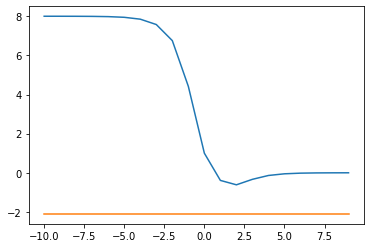

In [2480]:
#two spin up two spin down
H = K_spin(2,4) + 4*D_spin(2,4)
e,y = np.linalg.eig(H)
e = np.sort(e)

eg = []
eT = []
gl = []
for gi in range(-10,10):
    g = gi
    egl = find_energy_paulis(g,1,4,2,4)
    eg.append(egl)
    gl.append(g)
    eT.append(e[0])

plt.plot(gl,eg)
plt.plot(gl,eT)
print(e)

## Full thing using gates

Notice that the slatter statevector is the same in all sets up to a weight.  Therefore, doing off diagonal brakets can be handeled completely classically.  

Additionally, g does not chenge the structure of the pualis but only the wieghts.  Therefore, only one run has to be done on the quantum computer, the rest can be delt with classically.  

The method will be to 

1) sort out a collection of unique pauli terms

2) measure each of those terms on the qunatum computer.

3) use those measurments to construct a calculation of the brackets.  

### Find the collection of unique Pauli terms

In [2481]:
def pauli_collection(Ops):
    out = {}
    for O in Ops:
        keys = list(O.keys())
        for key in keys:
            block = O[key]
            for p in block:
                pauli = p.primitive.to_label()
                if pauli not in out:
                    out[pauli] = 0
    return out

paulis = pauli_collection([GHG_paulis(2,1,4,2,4),norm_paulis(2,2,4)])


### Create circuits

In [2482]:
from qiskit import QuantumCircuit, transpile, QuantumRegister,ClassicalRegister, execute


def create_circ(p_label):
    psi0 = np.array([0.5,1,0.5,0.5,0,-0.5,0,0])/np.sqrt(2)
    qbits = [0,1,2]
    qr = QuantumRegister(3)
    cr = ClassicalRegister(3)
    qc = QuantumCircuit(qr , cr)
    qc.initialize(psi0,qbits)
    qc_trans = transpile(qc,basis_gates = ['cx','ry','rz'])
    psi = copy.deepcopy(qc_trans)
    pauli_qs = []
    Z_label = ''
    Q = len(p_label)-1
    for q,p in enumerate(p_label):
        if p == 'X':
            psi.ry(-np.pi/2,qbits[Q-q])
            pauli_qs.append(1)
            Z_label += 'Z'
        if p == 'Y':
            psi.rx(np.pi/2,qbits[Q-q])
            pauli_qs.append(1)
            Z_label += 'Z'
        if p == 'Z':
            pauli_qs.append(1)
            Z_label += 'Z'
        if p == 'I':
            pauli_qs.append(0)
            Z_label += 'I'
    psi.measure(psi.qubits,psi.clbits)
    return [psi,pauli_qs,p_label]

def create_circs(paulis):
    keys = list(paulis.keys())
    circs = []
    meas = []
    labels = []
    for key in keys:
        ck, mk, lk = create_circ(key)
        circs.append(ck)
        meas.append(mk)
        labels.append(lk)
    return circs, meas, labels


In [2483]:
circs,meas,labels  = create_circs(paulis)

In [2484]:

pi = 5
print(labels[pi])
print(meas[pi])
circs[pi].draw()

IXZ
[0, 1, 1]


global phase: π/8
           ┌────────────┐                                               »
q35024_0: ─┤ Ry(1.7317) ├───────────────────────────────────────────────»
          ┌┴────────────┤           ┌───┐┌─────────────┐┌─────────┐┌───┐»
q35024_1: ┤ Ry(0.56394) ├───────────┤ X ├┤ Ry(0.56394) ├┤ Rz(π/4) ├┤ X ├»
          ├─────────────┤┌─────────┐└─┬─┘└─────────────┘└─────────┘└─┬─┘»
q35024_2: ┤ Ry(0.72273) ├┤ Rz(π/4) ├──■──────────────────────────────■──»
          └─────────────┘└─────────┘                                    »
  c696: 3/══════════════════════════════════════════════════════════════»
                                                                        »
«                      ┌───┐┌─────────────┐┌───┐┌──────────────┐┌───┐»
«q35024_0: ────────────┤ X ├┤ Ry(0.94627) ├┤ X ├┤ Ry(-0.62452) ├┤ X ├»
«          ┌──────────┐└─┬─┘└─────────────┘└─┬─┘└──────────────┘└─┬─┘»
«q35024_1: ┤ Rz(-π/4) ├──■───────────────────┼────────────────────■──»
«          └──────────┘                      │                       »
«q35024_2: ──────────────────────────────────■───────────────────────»
«                                                                    »
«  c696: 3/══════════════════════════════════════════════════════════»
«                                                                    »
«          ┌─────────────┐┌──────────┐┌───┐┌──────────┐┌───┐┌─────────┐┌───┐»
«q35024_0: ┤ Ry(0.16088) ├┤ Rz(-π/4) ├┤ X ├┤ Rz(-π/4) ├┤ X ├┤ Rz(π/4) ├┤ X ├»
«          └─────────────┘└──────────┘└─┬─┘└──────────┘└─┬─┘└─────────┘└─┬─┘»
«q35024_1: ─────────────────────────────■────────────────┼───────────────■──»
«                                                        │      ┌─┐         »
«q35024_2: ──────────────────────────────────────────────■──────┤M├─────────»
«                                                               └╥┘         »
«  c696: 3/══════════════════════════════════════════════════════╩══════════»
«                                                                2          »
«          ┌─────────┐ ┌─┐   
«q35024_0: ┤ Rz(π/4) ├─┤M├───
«          ├─────────┴┐└╥┘┌─┐
«q35024_1: ┤ Ry(-π/2) ├─╫─┤M├
«          └──────────┘ ║ └╥┘
«q35024_2: ─────────────╫──╫─
«                       ║  ║ 
«  c696: 3/═════════════╩══╩═
«                       0  1

### Measure Circuits

In [2493]:
from qiskit import IBMQ,transpile
from qiskit.tools.monitor import job_monitor
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-afrl', group='air-force-lab', project='quantum-sim')
backend = provider.get_backend('ibmq_jakarta')

In [2514]:
from qiskit import Aer
import copy

def get_results(circs_in, method = 'matrix',save_id_file = None):
    circs = copy.deepcopy(circs_in)
    #Exact Calculation
    if method == 'matrix':
        # add results
        r = []
        for l in range(len(circs)):
            circs[l].remove_final_measurements()
            wave = qi.Statevector.from_instruction(circs[l])
            r_l = wave.probabilities_dict()
            r.append(r_l)
    #Qiskit Simulation        
    if method == "simulator":
        sim = Aer.get_backend("qasm_simulator")
        r = execute(circs, backend = sim).result().get_counts() 
    #Device
    if method == "quantum":
        job = backend.run(transpile(circs, backend), meas_level=2, shots=8192)
        job_id = job.job_id()
        print(job_id)
        np.save(save_id_file,[job_id])
        r = job.result().get_counts()
    return r

results = get_results(circs)
#results = get_results(circs, method = 'simulator')

#save_id_file = "/Users/stenger/Documents/Research/Half_Classical_Evolution/Data/Job_id_test"
#results = get_results(circs, method = 'quantum',save_id_file = save_id_file)

In [2515]:
def analyze_result(r,meas):
    qbits = [0,1,2]
    QL=len(list(r.keys())[0])
    Q = len(meas)
    z_measure = 0
    total = 0
    for key in list(r.keys()):
        n = 0
        for q in range(Q):
            if key[QL-1-qbits[q]] == '1' and meas[Q-1-q] == 1:
                n += 1
        z_measure += (-1)**n * r[key] 
        total += r[key]
    return z_measure/total

def analyze_results(r,meas,labels):
    paulis = {}
    for pi in range(len(r)):
        paulis[labels[pi]] = analyze_result(r[pi],meas[pi])
    return paulis


pauli_meas = analyze_results(results,meas,labels)

### Calculate Bracket

The brackets are of the form
$$ <\psi_i|O_{ij}|\psi_j> $$
where $i$ and $j$ label the blocks.

The operator is a composed of pauli components $P_{ij,p}$ and weights $w_{ij,p}$
$$ O_{ij} = \sum_p w_{ij,p}P_{ij,p} $$

The statevectors are all of the same form $|\bar{\psi}>$ but with different wieghts $\alpha_i$
$$ |\psi_i> = \alpha_i  |\bar{\psi}>$$

So the braket can be expressed as,
$$ <\psi_i|O_{ij}|\psi_j> = \alpha_i^*\alpha_j \sum_p w_{ij,p} <\bar{\psi}|P_{ij,p}|\bar{\psi}> $$

In [2516]:
def alphas(psi_comp):
    keys = list(psi_comp.keys())
    total = sum(Mdot([psi_comp[key],psi_comp[key]]) for key in keys)
    a = {}
    for key in keys:
        a[key] = np.sign(psi_comp[key][0])*np.sqrt(Mdot([psi_comp[key],psi_comp[key]])/total)
    return a

def bkt_from_result(p_meas, O, psi):
    out = 0
    #check =[]
    a = alphas(psi)
    block_keys = list(O.keys())
    for bk in block_keys:
        for pauli in O[bk]:
            p = pauli.primitive.to_label()
            w = pauli.coeff
            if bk[0] == bk[2]:
                out += a[bk[0]]*a[bk[2]]*w*p_meas[p]
            else:
                out += 2*a[bk[0]]*a[bk[2]]*w*p_meas[p]
            #check.append([bk,p,a[bk[0]]*a[bk[2]]*w*p_meas[p]])
    return out
    #return check
        

In [2517]:
tst1 = bkt_from_result(pauli_meas,norm_paulis(2,2,4),psi_comp)
tst2 = Mdot([psi_spin(2,4),norm_spin(2,2,4),psi_spin(2,4)])
print('check that norm has the right expectation value:', tst1-tst2)

check that norm has the right expectation value: (2.7755575615628914e-17+0j)


In [2518]:
tst1 = bkt_from_result(pauli_meas,GHG_paulis(2,1,4,2,4),psi_comp)
tst2 = bkt_paulis(psi_comp,GHG_paulis(2,1,4,2,4),psi_comp)
print('check that GHG has the right expectation values:', tst1-tst2)

check that GHG has the right expectation values: (6.938893903907228e-18+0j)


In [2519]:
def energy_from_results(r,g,k,d,Ns,N):
    num = bkt_from_result(pauli_meas,GHG_paulis(g,k,d,Ns,N),psi_comp)
    dnm = bkt_from_result(pauli_meas,norm_paulis(g,Ns,N),psi_comp)
    return num/dnm
    

In [2520]:
energy_from_results(results,2,1,4,2,4)

-0.6151399249253594

In [2523]:
k=1
d=4
Ns=2
N=4

H = k*K_spin(Ns,N) + d*D_spin(Ns,N)
e,y = np.linalg.eig(H)
e = np.sort(e)



eg = []
gl = []
eT = []
for gi in range(-10,10):
    g = gi
    egl = energy_from_results(results,g,k,d,Ns,N)
    eg.append(egl)
    gl.append(g)
    eT.append(e[0])



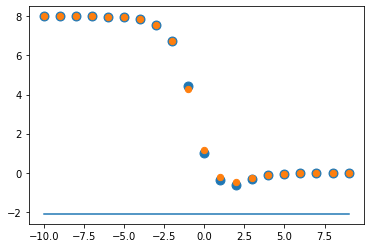

In [2524]:
plt.scatter(gl,eg,s=80)
plt.scatter(gl,eg_h,s=40)
plt.plot(gl,eT)
#print(e)

So from just one run of the quantum computer you can construct the energy for all g, k, and d

### Save Results

In [2508]:
import pickle
T=0
fpath = "/Users/stenger/Documents/Research/Half_Classical_Evolution/Data/Job_id_test"

file_to_store = open(fpath + "Gutz_matrix_test.pickle", "wb")

pickle.dump(results, file_to_store)

In [2511]:
import pickle
fpath = "/Users/stenger/Documents/Research/Half_Classical_Evolution/Data/Job_id_test"

file_to_read = open(fpath + "Gutz_jakarta_test.pickle", "rb")

loaded_results = pickle.load(file_to_read)

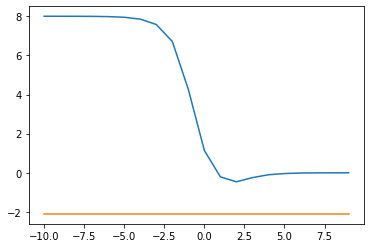

In [2512]:
k=1
d=4
Ns=2
N=4

H = k*K_spin(Ns,N) + d*D_spin(Ns,N)
e,y = np.linalg.eig(H)
e = np.sort(e)



eg = []
gl = []
eT = []
for gi in range(-10,10):
    g = gi
    egl = energy_from_results(loaded_results,g,k,d,Ns,N)
    eg.append(egl)
    gl.append(g)
    eT.append(e[0])

plt.plot(gl,eg)
plt.plot(gl,eT)